In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [223]:
file_name = "general_env"
data = pd.read_csv(f"{file_name}/{file_name}.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [224]:
def save_train_test_split(data, file_name):
    n_rows = data.shape[0]
    split_ind = int(n_rows * .7)

    train_data = data.iloc[:split_ind]
    test_data = data.iloc[split_ind:]

    # Сохранение тренировочного набора в файл
    train_data.to_csv(f'{file_name}/train_data.csv', index=False)

    # Сохранение тестового набора в файл
    test_data.to_csv(f'{file_name}/test_data.csv', index=False)
    
save_train_test_split(data, file_name)

In [225]:
# detect negative timestamp deltas
track_durations = (data['timestamp'].diff().dt.total_seconds() / 60).values[1:]
neg_dur = np.argwhere(track_durations < 0)
pairs = np.hstack((neg_dur-2, neg_dur+3))

for fr, to in pairs:
    print(data.iloc[fr: to])

In [201]:
data.head(20)

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top
0,2019-03-09 14:10:39,61,50,0.719967,5,False,[ 0 24 69 68 34 17 19 63 20 61]
1,2019-03-09 14:14:09,61,65,0.624211,5,False,[49 53 16 71 39 19 24 62 59 54]
2,2019-03-09 14:16:09,61,40,0.611021,4,False,[49 67 57 54 53 50 48 47 46 45]
3,2019-03-09 14:18:09,61,4,0.656288,5,False,[49 41 32 34 35 37 38 40 45 63]
4,2019-03-09 14:22:07,61,57,0.629869,4,False,[49 17 74 13 72 71 14 38 67 16]
5,2019-03-09 14:24:59,61,2,0.741741,5,False,[ 0 79 17 20 68 67 65 63 24 57]
6,2019-03-09 14:28:03,61,27,0.596290,4,False,[ 0 75 72 71 70 38 16 19 20 61]
7,2019-03-09 14:32:05,61,83,0.570580,4,False,[ 0 54 75 16 71 17 39 67 24 59]
8,2019-03-09 14:35:25,61,46,0.690878,4,False,[ 0 75 17 71 70 69 67 20 65 57]
9,2019-03-09 14:39:02,61,58,0.602219,4,False,[ 0 24 71 70 69 36 67 19 20 61]


In [226]:
def get_episodes(data):
    ends = data[data['terminated'] == True].index.values
    starts = np.zeros_like(ends)
    starts[1:] = ends[:-1] + 1
    episodes = pd.DataFrame(starts, columns=['start'])
    episodes['end'] = ends
    episodes['start_time'] = data.iloc[starts]['timestamp'].values
    episodes['end_time'] = data.iloc[ends]['timestamp'].values
    episodes['duration_min'] = (episodes['end_time'] - episodes['start_time']).dt.total_seconds() / 60
    return episodes

get_episodes(data).head(10)

,start,end,start_time,end_time,duration_min
0,0,25,2019-03-09 14:10:39,2019-03-09 15:28:25,77.766667
1,26,80,2019-03-10 00:20:44,2019-03-10 03:24:04,183.333333
2,81,122,2019-03-10 10:21:24,2019-03-10 12:41:17,139.883333
3,123,180,2019-03-10 13:55:32,2019-03-10 16:54:34,179.033333
4,181,235,2019-03-10 18:38:26,2019-03-10 21:28:57,170.516667
5,236,282,2019-03-11 03:14:07,2019-03-11 05:42:55,148.800000
6,283,337,2019-03-11 06:02:37,2019-03-11 08:47:16,164.650000
7,338,373,2019-03-11 10:14:24,2019-03-11 12:03:40,109.266667
8,374,414,2019-03-11 15:33:49,2019-03-11 17:43:53,130.066667
9,415,449,2019-03-11 22:18:33,2019-03-12 00:01:33,103.000000


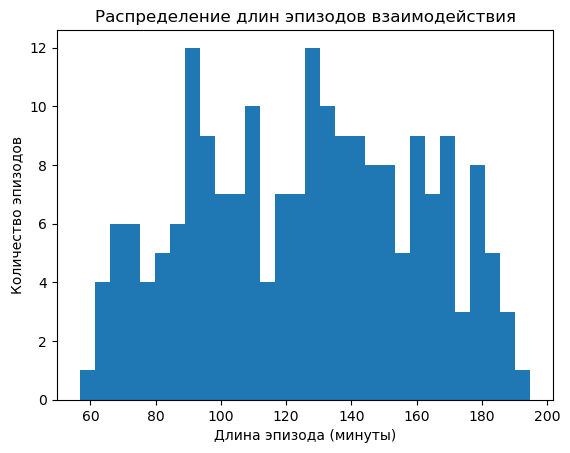

In [227]:
def plot_interaction_lengths(data, ax=None):
    # Построение графика распределения длин эпизодов взаимодействия
    episodes = get_episodes(data)

    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['duration_min'], bins=30)
    ax.set_title('Распределение длин эпизодов взаимодействия')
    ax.set_xlabel('Длина эпизода (минуты)')
    ax.set_ylabel('Количество эпизодов')


plot_interaction_lengths(data)

In [228]:
def plot_interactions_per_episode(data, ax=None):
    # Построение гистограммы распределения количества взаимодействий за эпизод
    episodes = get_episodes(data)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['end'] - episodes['start'] + 1, bins=30)
    ax.set_title('Распределение количества взаимодействий за эпизод')
    ax.set_xlabel('Количество взаимодействий за эпизод')
    ax.set_ylabel('Количество эпизодов')

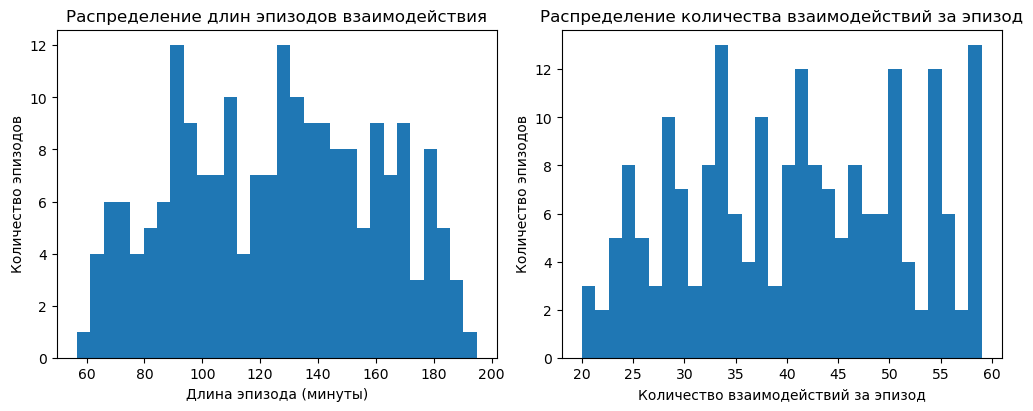

In [229]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

plot_interaction_lengths(data, axs[0])
plot_interactions_per_episode(data, axs[1])

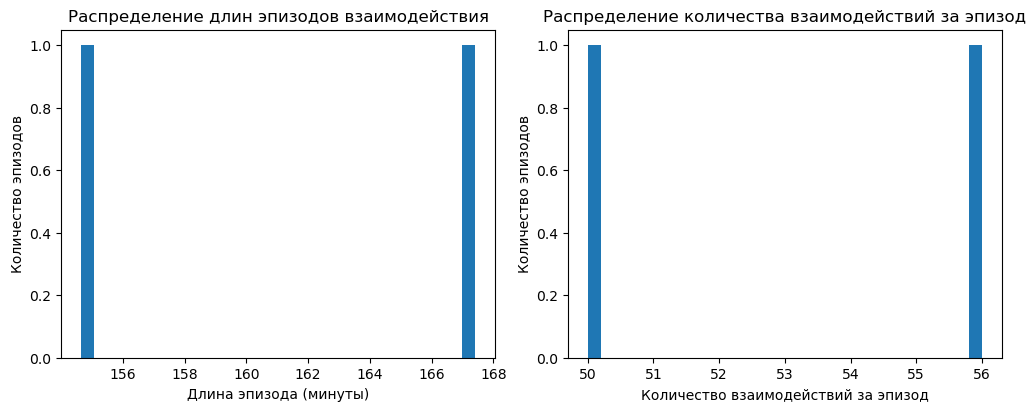

In [230]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_0 = data[data['user_idx'] == 6].copy()
user_0.reset_index(inplace=True)

plot_interaction_lengths(user_0, axs[0])
plot_interactions_per_episode(user_0, axs[1])

In [231]:
def plot_relevance_distribution(data, discr=True, user_id=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    
    if ax is None:
        ax = plt.subplot(1,1,1)
    
    col = 'relevance_int' if discr else 'relevance_cont'
        
    # Построение гистограммы распределения relevance_int
    ax.hist(data[col].dropna(), bins=30)
    ax.set_title(f'Распределение {col} для пользователя {user_id}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')


def plot_item_distribution(data, user_id=None, rel=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    if rel is not None:
        data = data[data['relevance_int'] > rel]

    if ax is None:
        ax = plt.subplot(1,1,1)
        
    # Построение гистограммы распределения item_idx
    ax.hist(data['item_idx'].dropna(), bins=30)
    ax.set_title('Распределение item_idx для пользователя {}'.format(user_id))
    ax.set_xlabel('item_idx')
    ax.set_ylabel('Количество')

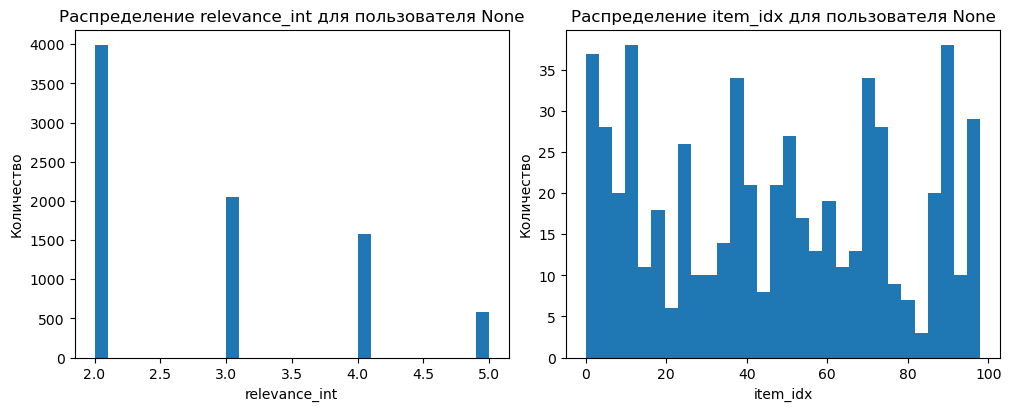

In [236]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

# set None to see for all users
user_id = None
plot_relevance_distribution(data, discr=True, user_id=user_id, ax=axs[0])  # Добавлен вызов новой функции
plot_item_distribution(data, user_id=user_id, rel=4, ax=axs[1])  # Добавлен вызов новой функции

In [237]:
user = data[data['user_idx'] == 0]
user

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top
5882,2019-04-24 11:04:25,0,33,0.108435,2,False,[14 99 36 27 28 29 30 31 32 33]
5883,2019-04-24 11:06:33,0,39,0.104778,2,False,[99 36 26 27 28 29 30 31 32 33]
5884,2019-04-24 11:08:44,0,65,0.107109,2,False,[99 36 26 27 28 29 30 31 32 33]
5885,2019-04-24 11:12:57,0,54,0.124558,2,False,[99 36 26 27 28 29 30 31 32 33]
5886,2019-04-24 11:16:39,0,2,0.126032,2,False,[99 36 26 27 28 29 30 31 32 33]
5887,2019-04-24 11:20:09,0,3,0.103249,2,False,[99 36 26 27 28 29 30 31 32 33]
5888,2019-04-24 11:24:22,0,30,0.110859,2,False,[99 36 26 27 28 29 30 31 32 33]
5889,2019-04-24 11:27:22,0,62,0.104990,2,False,[99 36 26 27 28 29 30 31 32 33]
5890,2019-04-24 11:29:54,0,31,0.107013,2,False,[ 9 99 37 27 28 29 30 31 32 33]
5891,2019-04-24 11:33:22,0,97,0.154641,2,False,[50 51 99 36 27 28 29 30 31 32]


,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top
5882,2019-04-24 11:04:25,0,33,0.108435,2,False,[14 99 36 27 28 29 30 31 32 33]
5883,2019-04-24 11:06:33,0,39,0.104778,2,False,[99 36 26 27 28 29 30 31 32 33]
5884,2019-04-24 11:08:44,0,65,0.107109,2,False,[99 36 26 27 28 29 30 31 32 33]
5885,2019-04-24 11:12:57,0,54,0.124558,2,False,[99 36 26 27 28 29 30 31 32 33]
5886,2019-04-24 11:16:39,0,2,0.126032,2,False,[99 36 26 27 28 29 30 31 32 33]
5887,2019-04-24 11:20:09,0,3,0.103249,2,False,[99 36 26 27 28 29 30 31 32 33]
5888,2019-04-24 11:24:22,0,30,0.110859,2,False,[99 36 26 27 28 29 30 31 32 33]
5889,2019-04-24 11:27:22,0,62,0.104990,2,False,[99 36 26 27 28 29 30 31 32 33]
5890,2019-04-24 11:29:54,0,31,0.107013,2,False,[ 9 99 37 27 28 29 30 31 32 33]
5891,2019-04-24 11:33:22,0,97,0.154641,2,False,[50 51 99 36 27 28 29 30 31 32]


In [238]:
def save_dict_as_yaml_config(config_dict, file_name):
    from ruamel import yaml
    with open(f"{file_path}", "w") as file:
        yaml = yaml.YAML()
        yaml.indent(sequence=4, offset=2)
        yaml.dump(config_dict, file)
        
my_dict = {'name': 'eval_on_cases',
 'group_name': 'DCQL_pure_best',
 'seed': 42,
 'use_wandb': True,
 'eval_online': True,
 'env_path': 'environments/env_random',
 'looking_for': '0,1,5',
 'experiment': {'top_k': 10,
  'data_path': 'environments/env_best/train_data.csv',
  'test_data_path': 'environments/env_best/test_data.csv',
  'col_mapping': {'user_col_name': 'user_idx',
   'item_col_name': 'item_idx',
   'reward_col_name': 'relevance_int',
   'timestamp_col_name': 'timestamp'},
  'mdp_settings': {'framestack_size': 10,
   'reward_function_name': 'relevance_based_reward',
   'action_function_name': 'next_item_action',
   'episode_splitter_name': 'full_user_interaction',
   'history_keys': ['framestack', 'user_id']},
  'scorer': {'metrics': ['ndcg', 'PC', 'ihitrate', 'stat_hitrate'],
   'tresh': '[0.5, 0.7]',
   'prediction_type': 'discrete'},
  'algo_settings': {'n_epochs': 300,
   'general_parametrs': {'algo': 'DCQL', 'batch_size': 1024, 'use_gpu': False},
   'model_parametrs': {'use_als': False,
    'user_num': 100,
    'item_num': 100,
    'emb_dim': 5,
    'hid_dim': 256,
    'memory_size': 10,
    'feature_size': 512,
    'state_repr_name': 'full_history',
    'freeze_emb': False,
    'attention_hidden_size': 32}}}}

# save_dict_as_yaml_config('_config.yaml', my_dict)